### Importing modules

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import itertools
import pickle
import os

from IPython.display import clear_output

from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras import regularizers

import tensorflow_addons as tfa

from tensorflow import keras
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

### Constants

In [3]:
# DIRECTORIES

DATASET = []
DATASET.append("./dataset2/Brain Tumor Data Set/Brain Tumor Data Set_pp100")

DATASET_PP = []
TRAIN_PATH = []
TEST_PATH = []
CLASS_LABELS = []
NUM_OF_CLASSES = []


for ii, ds in enumerate(DATASET):
    DATASET_PP.append(ds)
    TRAIN_PATH.append(ds + "/Train")
    TEST_PATH.append(ds + "/Test")
    CLASS_LABELS.append([filename for filename in os.listdir(TRAIN_PATH[ii])])
    NUM_OF_CLASSES.append(len(CLASS_LABELS[ii]))


# OTHER

IMG_SIZE = (244, 244)
BATCH_SIZE = 32

In [4]:
r_seeds = ["Dimitra"]

## Function Definitions

### Data Augmentation

In [5]:
def data_augmentation(r, s):
    # here we will define just the ImageDataGenrator
    # with 0 as the validation split to keep all the images of the traindataset
    # as currently in the train directory
    # we will split this to train-validation sets within the KFold loop

    random.seed(r)

    trn_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=s,
        rotation_range=20,          # randomly rotate the images by 20 degrees
        zoom_range=0.2,             # randomly zoom in/out on the images by 20%
        horizontal_flip=True,       # randomly flip the images horizontally
        vertical_flip=False,        # don't flip the images vertically
        width_shift_range=0.1,      # randomly shift the images horizontally by 10%
        height_shift_range=0.1,     # randomly shift the images vertically by 10%
        shear_range=0.1,            # apply random shear transformations
        fill_mode='nearest'         # fill in any empty pixels with the nearest available pixel
        )
    
    return trn_datagen

In [6]:
def test_data(tst_path, idx, img_size, batch_size):
    # and we can also define the test generator

    tst_datagen = ImageDataGenerator(rescale=1./255)


    tst_generator = tst_datagen.flow_from_directory(tst_path[idx],
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)
    return tst_generator

In [7]:
def plot_train_history(h, save2f = ''):
    
    hm=['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score']
    e = len(h.history['loss'])

    # Plot metric values for the current seed
    plt.figure(figsize=(12, 6))

    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.plot(range(1, e+1), h.history[hm[i]], label=hm[i])
        plt.title(hm[i])
        plt.xticks([])
        
        
    plt.tight_layout()
    
    if save2f != '':
        plt.savefig("outputs/" + save2f + ".png")

    plt.show()

In [8]:
def plot_training_histories(seed_data, save2f=''):
    
    hm=['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score']
    
    for sd in list(seed_data.keys()):
        for dset in list(seed_data[sd].keys()):
            print(f"Seed = {sd} | Dataset index: {dset}")
            h = seed_data[sd][dset][1]
          
            e = len(h.history['loss'])

            # Plot metric values for the current seed
            plt.figure(figsize=(12, 6))

            for i in range(6):
                plt.subplot(2, 3, i+1)
                plt.plot(range(1, e+1), h.history[hm[i]], label=hm[i])
                plt.title(f"{sd} > ds idx : {dset} > {hm[i]}")
                plt.xticks([])
                plt.tight_layout()
                
                if save2f != '':
                    plt.savefig("outputs/" + save2f + ".png")

            plt.show()

In [9]:
def string_to_int(my_seed):
    
    if isinstance(my_seed, str):
        ascii_values = 0
        for char in my_seed:
            ascii_values += ord(char)
        return int(ascii_values)
    else:
        return my_seed

# Transfer Learning

## Base Model : ResNet50v2

### Model definition

In [11]:
def my_ResNet_model(c, show_summary=False):
    tf.keras.backend.clear_session()

    base_model = ResNet50V2(input_shape=IMG_SIZE+(3,), include_top=False)
    base_model.trainable = False

    mymodel = Sequential([base_model, 
                          GlobalAveragePooling2D(),
                          Flatten(),
                          Dense(256, activation="relu", kernel_initializer='he_normal'),
                          Dropout(0.3),
                          Dense(c, activation='softmax')
                          ])

    mymodel.compile(optimizer=Adam(), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy',
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.Recall(),
                             tf.keras.metrics.AUC(),
                             tfa.metrics.F1Score(num_classes=c, average='macro')
                             ])
    
    if show_summary:
        mymodel.summary()
    
    return mymodel

In [13]:
# show an example of a model summary for 2 classes
my_ResNet_model(2, show_summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

### Model training for different seeds and datasets

In [15]:
seed_results = {}

for rs in r_seeds:
    
    ds_results = {}

    for ds_idx in range(len(DATASET)):
        
        start_time = time.time()

        random.seed(rs)
        
        print(f"\n################################################################################### Seed: {rs} | DS: {ds_idx}")
        
        print(f"\n::::::::::::::::::::::::::::::::::::::::::::::::::::: (Train, Val)")

        train_datagen = data_augmentation(rs, 0.2) 
        
        train_generator = train_datagen.flow_from_directory(TRAIN_PATH[ds_idx],
                                                            target_size=IMG_SIZE,
                                                            batch_size=BATCH_SIZE,
                                                            class_mode='categorical',
                                                            shuffle=True,
                                                            subset='training'
                                                            )

        val_generator = train_datagen.flow_from_directory(TRAIN_PATH[ds_idx],
                                                        target_size=IMG_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        subset='validation'
                                                        )
        
        # test_datagen = ImageDataGenerator(rescale=1./255)
        # test_generator = test_datagen.flow_from_directory(TEST_PATH[ds_idx],
        #                                                 target_size=IMG_SIZE,
        #                                                 batch_size=BATCH_SIZE,
        #                                                 class_mode='categorical',
        #                                                 shuffle=False)
        
        print(f"\n::::::::::::::::::::::::::::::::::::::::::::::::::::: Training")

        es = EarlyStopping(monitor="val_accuracy", 
                        mode="max",
                        restore_best_weights=True,
                        patience=6)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=2, min_lr=0.0000001)
        
        
        int_seed = string_to_int(rs)
        np.random.seed(string_to_int(int_seed))
        tf.random.set_seed(int_seed)

        model = my_ResNet_model(NUM_OF_CLASSES[ds_idx])
        
        hist = model.fit(train_generator,
                        epochs=30,
                        validation_data=val_generator,
                        callbacks=[es, reduce_lr]
                        )

        end_time = time.time()
        elapsed_time = end_time - start_time

        ds_results[ds_idx] = [model, hist,elapsed_time]

    seed_results[rs] = ds_results




################################################################################### Seed: Dimitra | DS: 0

::::::::::::::::::::::::::::::::::::::::::::::::::::: (Train, Val)
Found 2596 images belonging to 2 classes.


Found 648 images belonging to 2 classes.

::::::::::::::::::::::::::::::::::::::::::::::::::::: Training
Epoch 1/30
82/82 [==============================] - 128s 2s/step - loss: 0.3625 - accuracy: 0.8475 - precision: 0.8475 - recall: 0.8475 - auc: 0.9261 - f1_score: 0.8443 - val_loss: 0.2659 - val_accuracy: 0.8920 - val_precision: 0.8920 - val_recall: 0.8920 - val_auc: 0.9573 - val_f1_score: 0.8909 - lr: 0.0010
Epoch 2/30
82/82 [==============================] - 130s 2s/step - loss: 0.2123 - accuracy: 0.9183 - precision: 0.9183 - recall: 0.9183 - auc: 0.9718 - f1_score: 0.9168 - val_loss: 0.2299 - val_accuracy: 0.9136 - val_precision: 0.9136 - val_recall: 0.9136 - val_auc: 0.9673 - val_f1_score: 0.9129 - lr: 0.0010
Epoch 3/30
82/82 [==============================] - 128s 2s/step - loss: 0.1683 - accuracy: 0.9353 - precision: 0.9353 - recall: 0.9353 - auc: 0.9825 - f1_score: 0.9340 - val_loss: 0.2071 - val_accuracy: 0.9259 - val_precision: 0.9259 - val_recall: 0.9259 - val_auc: 0.9713 -

### Plot Histories of all

Seed = Dimitra | Dataset index: 0


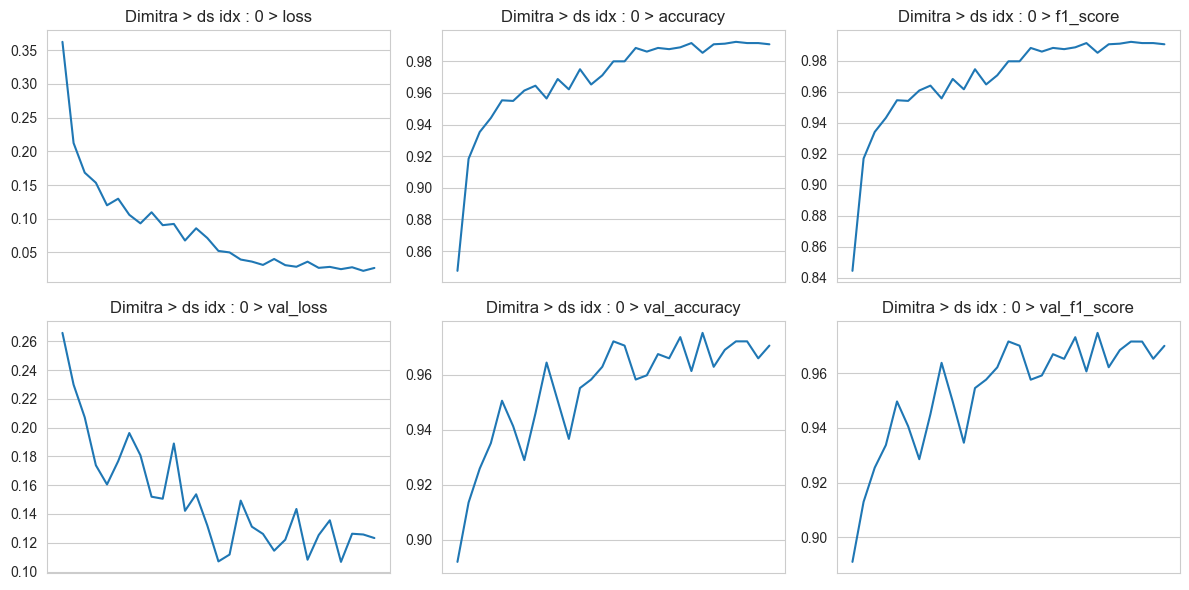

In [16]:
plot_training_histories(seed_results)

### Test accuracies and confusion matrices for the trained models

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:   
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Hide gridlines
    plt.grid(False)

    plt.show()

In [22]:
def cal_test_accuracies(seed_data, tst_pth, save2f=''):
    
    tst_acc = []
    
    for sd in list(seed_data.keys()):
        for dset in list(seed_data[sd].keys()):
            
            comb_label = f'Seed = "{sd}" | DS_idx: {dset}\n'
            print(comb_label)

            test_datagen = ImageDataGenerator(rescale=1./255);
            test_generator = test_datagen.flow_from_directory(tst_pth[dset],
                                                            target_size=IMG_SIZE,
                                                            batch_size=BATCH_SIZE,
                                                            class_mode='categorical',
                                                            shuffle=False)
            
            m = seed_data[sd][dset][0];

            y_pred_val_prob = m.predict(test_generator);
            y_pred = np.argmax(y_pred_val_prob, axis=1);
            y_true_val = test_generator.classes;
            test_accuracy = accuracy_score(y_true_val, y_pred);
            tst_acc.append([sd,dset,test_accuracy])
    
            print(f"Test Accuracy = {test_accuracy:.1%}\n")
            print("Classification report:\n", classification_report(y_pred,y_true_val,target_names=CLASS_LABELS[dset]))

            confusion_mtx = confusion_matrix(y_true_val, y_pred) 
            cm = plot_confusion_matrix(confusion_mtx, classes = CLASS_LABELS[dset], title = comb_label, normalize=True)
            

Seed = "Dimitra" | DS_idx: 0

Found 812 images belonging to 2 classes.


26/26 [==============================] - 28s 1s/step
Test Accuracy = 97.3%

Classification report:
               precision    recall  f1-score   support

 Brain Tumor       0.98      0.98      0.98       461
     Healthy       0.97      0.97      0.97       351

    accuracy                           0.97       812
   macro avg       0.97      0.97      0.97       812
weighted avg       0.97      0.97      0.97       812



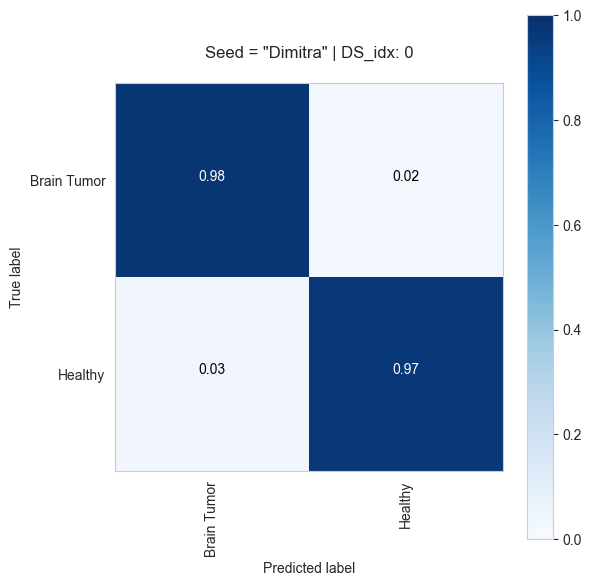

In [23]:
cal_test_accuracies(seed_results, TEST_PATH);

# END